In [1]:
import reading
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, InputLayer, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv3D, AveragePooling2D, AveragePooling3D, MaxPooling2D, MaxPooling3D,GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc
import os
from tensorflow.keras import layers

2023-03-13 16:29:30.775060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 16:29:31.131088: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 16:29:31.131107: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 16:29:32.384311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
paths_FA= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_FA_image")


paths_FA.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))


dataset=pd.DataFrame(pd.read_csv('/home/francesco/CompProject/ADNI_dataset_diffusion.csv'))
dataset.sort_values(by=["Subject"],inplace=True)
dataset["Path"]=paths_FA
pd.set_option("max_colwidth",None)

dataset.head()

,Subject,Group,Sex,Age,Path
67,4002,0,F,74.0,Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4002/corrected_FA_image/2011-02-28_15_42_50.0/I397180/ADNI_098_S_4002_MR_corrected_FA_image_Br_20131105134057196_S100616_I397180.nii
68,4003,0,F,72.0,Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4003/corrected_FA_image/2011-03-22_09_23_47.0/I299742/ADNI_098_S_4003_MR_corrected_FA_image_Br_20120421215950180_S102157_I299742.nii
28,4009,1,M,90.0,Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/016_S_4009/corrected_FA_image/2011-06-18_12_22_12.0/I299644/ADNI_016_S_4009_MR_corrected_FA_image_Br_20120421205831338_S112088_I299644.nii
69,4018,0,M,76.0,Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4018/corrected_FA_image/2011-04-22_15_36_10.0/I299744/ADNI_098_S_4018_MR_corrected_FA_image_Br_20120421220032350_S105027_I299744.nii
70,4050,0,M,77.0,Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4050/corrected_FA_image/2011-05-27_15_33_58.0/I299745/ADNI_098_S_4050_MR_corrected_FA_image_Br_20120421220057813_S110467_I299745.nii


In [3]:
images_list = []
for i, datapath in enumerate(dataset["Path"]):
    image = np.asarray(nib.load(datapath).get_fdata())
    #image[image == 0] = float('NaN')
    images_list.append(image)
    
images = np.array(images_list, dtype='float64')
labels = np.array(dataset["Group"], dtype='int64')

DATA AUG

In [4]:

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

data_augmentation1 = Sequential([
    
            layers.RandomFlip(mode='horizontal_and_vertical'),
           
])


data_augmentation2 = Sequential([
    
            layers.RandomRotation((-0.5,0.5)),
         
])



data_augmentation3 = Sequential([
    
            layers.RandomZoom(0.5),
])



2023-03-13 16:29:53.060686: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-13 16:29:53.061133: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 16:29:53.061169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (francesco-jj): /proc/driver/nvidia/version does not exist
2023-03-13 16:29:53.062310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

imagesau2=data_augmentation2(images)







2023-03-13 16:29:55.802444: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1032856000 exceeds 10% of free system memory.


2023-03-13 16:29:56.783440: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 516428000 exceeds 10% of free system memory.


2023-03-13 16:29:58.400864: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 516428000 exceeds 10% of free system memory.


In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


imagesau3=data_augmentation3(images)


2023-03-13 16:30:11.845483: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1032856000 exceeds 10% of free system memory.


2023-03-13 16:30:12.713375: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 516428000 exceeds 10% of free system memory.


In [7]:
images1=np.append(images,imagesau2,axis=0)
#images2=np.append(images1,imagesau2,axis=0)


In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


images=np.append(images1,imagesau3,axis=0)




print(np.shape(images))


(291, 110, 110, 110)


In [9]:
labels1=np.append(labels,labels)
#labels2=np.append(labels1,labels)

labels=np.append(labels1,labels)


print(np.shape(labels))

(291,)


In [10]:
def split_2D():
    X_train, x_test, Y_train, y_test = train_test_split(images[:,:,:,53:56], labels, test_size=0.2, random_state=36)
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=97)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test = split_2D()
print(x_train.shape)

(174, 110, 110, 3)


In [12]:
def make_2D_CNN_best(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(4, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=2),
      #Dropout(0.4),False
      
      Conv2D(8, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((5,5), strides=2),
      #Dropout(0.4),False

      Flatten(),

      Dense(20, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [21]:
def make_2D_CNN_newbest(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(4, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=2),
      #Dropout(0.4),
      
      Conv2D(8, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((5,5), strides=2),
      #Dropout(0.4),

      Flatten(),

      Dense(20, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [89]:
def make_2D_CNN(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((1,1), strides=2),
      #Dropout(0.4),
      
      Conv2D(4, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((3,3), strides=2),
      #Dropout(0.4),
      
      Conv2D(8, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((4,4), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (5,5), padding='valid', input_shape=shape,kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),

      MaxPooling2D((5,5), strides=2),
      #Dropout(0.4),

      Flatten(),

      Dense(30, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [22]:
model = make_2D_CNN_newbest()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 106, 106, 2)       152       
                                                                 
 batch_normalization_4 (Batc  (None, 106, 106, 2)      8         
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 106, 106, 2)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 53, 53, 2)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 49, 49, 4)         204       
                                                                 
 batch_normalization_5 (Batc  (None, 49, 49, 4)       

In [23]:
model.compile(optimizer=SGD(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=10)

In [25]:
epochs= 1000
batch_size = 20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch = round(len(x_train)/batch_size),
                    verbose=1,
                    validation_data=(x_val, y_val),
                    validation_steps=round(len(x_val)/batch_size),
                    callbacks=[reduce_on_plateau, early_stopping])

Epoch 1/1000
9/9 [==============================] - 2s 94ms/step - loss: 1.0602 - accuracy: 0.4885 - val_loss: 0.8996 - val_accuracy: 0.5345 - lr: 0.1000
Epoch 2/1000
9/9 [==============================] - 1s 71ms/step - loss: 0.8605 - accuracy: 0.6379 - val_loss: 0.8903 - val_accuracy: 0.5690 - lr: 0.1000
Epoch 3/1000
9/9 [==============================] - 1s 71ms/step - loss: 0.8138 - accuracy: 0.6264 - val_loss: 0.8876 - val_accuracy: 0.5345 - lr: 0.1000
Epoch 4/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.8102 - accuracy: 0.6782 - val_loss: 0.8882 - val_accuracy: 0.5345 - lr: 0.1000
Epoch 5/1000
9/9 [==============================] - 1s 68ms/step - loss: 0.7601 - accuracy: 0.7414 - val_loss: 0.9970 - val_accuracy: 0.5345 - lr: 0.1000
Epoch 6/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.6613 - accuracy: 0.7759 - val_loss: 1.6758 - val_accuracy: 0.4655 - lr: 0.1000
Epoch 7/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.8

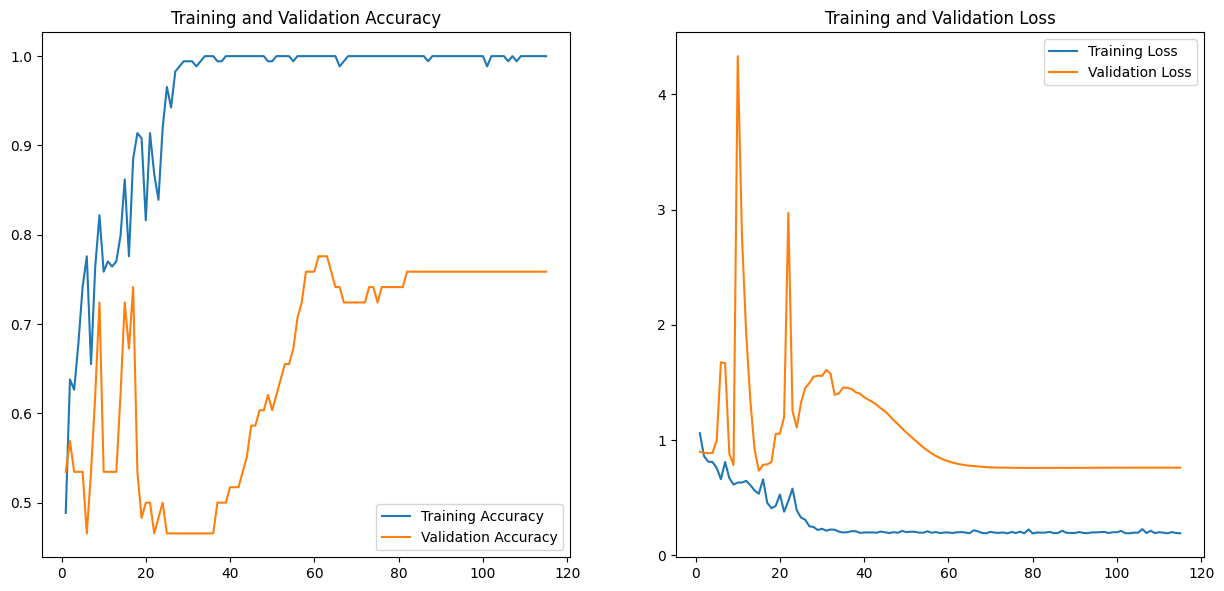

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation accuracy: 0.759
2/2 [==============================] - 0s 18ms/step
AUC = 0.853


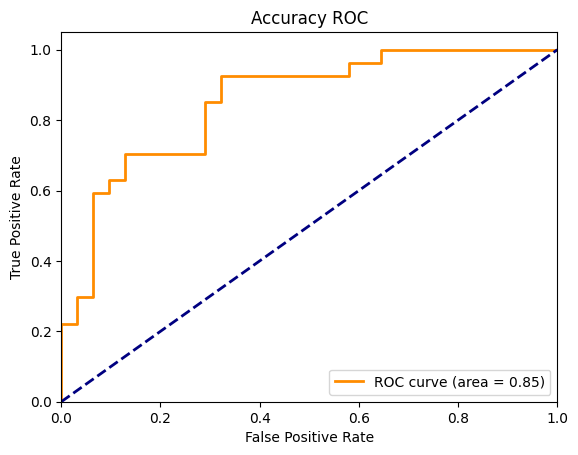

In [27]:
_, val_acc = model.evaluate(x_val, y_val, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))

preds = model.predict(x_val, verbose=1)
#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Accuracy ROC')
plt.legend(loc="lower right")
plt.show()

2/2 [==============================] - 0s 27ms/step - loss: 0.7656 - accuracy: 0.7966

Test accuracy: 0.797
2/2 [==============================] - 0s 23ms/step
AUC = 0.863


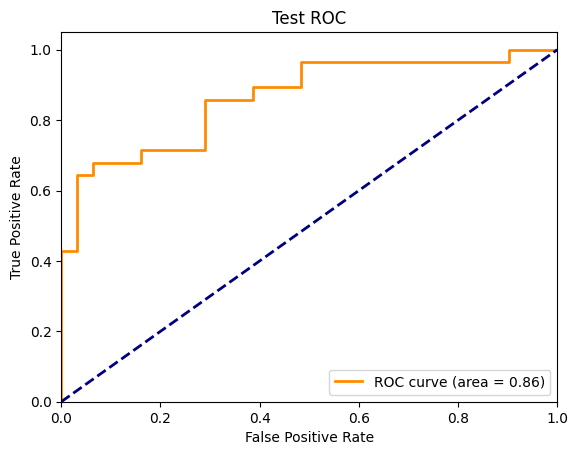

In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy: %.3f' % (test_acc))

preds_test = model.predict(x_test, verbose=1)
fpr, tpr, _ = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()